## Compute expected loss of energy in Lagrangian perspective

In [1]:
import xarray as xr
import numpy as np

from scipy import stats, fft

import matplotlib.pyplot as plt

import os
from glob import glob
import threading

import dask.dataframe as dd
from dask import delayed
import pandas as pd
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#w = cluster.scale(jobs=2)
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster
client

<Client: 'tcp://127.0.0.1:50524' processes=4 threads=4, memory=8.00 GiB>

In [3]:
def get_lagrangian_energy_loss(omega, bandwidth, ds, U=1, 
                               Ce=None,axis=-1, 
                               full_output=False,
                               _factor_dtau=100,
                               _factor_tau_max=100,
                              ):
    """ compute the lagrangian loss of energy following Caspar-Cohen et al. 2022
    
    Parameters
    ----------
    omega: float
        wave frequency
    bandwidth: float
        filter bandwidth
    ds: xr.Dataset
        Dataset containing T, k, Ubar, Tbar
    Ce: lambda
        Eulerian autocorrelation signature must look like Ce(tau, U, T)
    """
    # util params
    day2sec = 86400
#    U = 1
    omega0 = (omega[0]+omega[1])/2
    # check all variables are here
    input_variables = ["T", "k", "Ubar", "Tbar"]
    assert all([v in ds for v in input_variables]), \
        "one of T, k, Ubar, Tbar is missing from ds"
    ds = ds.set_coords(input_variables)

    # default autocorrelation
    if Ce is None:
        Ce = lambda tau, U, T: U * np.exp(-np.abs(tau/T)**2) * (np.cos(2*np.pi*omega[0]*tau) + np.cos(2*np.pi*omega[1]*tau))
        
    # derives Lagrangian
#    sigma = lambda tau, Ub, Tb: Tb*day2sec*Ub*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    sigma = lambda tau, Ub, Tb: (Tb*day2sec*Ub)*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    Cl = lambda tau, U, T, k, Ub, Tb: Ce(tau, U, T) * np.exp(- (sigma(tau, Ub, Tb)*k)**2 /2)

    # build lags
    tau_max = T*_factor_tau_max
    dtau = 2*np.pi/omega0/_factor_dtau
    ds = ds.assign_coords(tau=("tau", np.arange(0, tau_max, dtau)))
    
    # build covariance
    ds["Ce"] = Ce(ds.tau, U, ds["T"])
    #ds["sigma"] = sigma(ds.tau, ds.Ubar, ds.Tbar)
    #ds["exp_sigma"] = np.exp(- (sigma(ds.tau, ds.Ubar, ds.Tbar)*ds.k)**2 /2)
    ds["Cl"] = Cl(ds.tau, U, ds["T"], ds.k, ds.Ubar, ds.Tbar)
    # build power density spectrum
    N = ds.tau.size
    if axis==-1:
        input_dims_Ce, input_dims_Cl = ["tau"],["tau"]
        output_dims_Ce, output_dims_Cl = ["omega"], ["omega"]
    elif axis==0:
        dim = 'k'
        input_dims_Ce = ["tau"]#[d for d in ds.Ce.dims]
        output_dims_Ce = ["omega"]#+[d for d in ds.Ce.dims[1:]]
    
        input_dims_Cl = ["tau","k"]#[d for d in ds.Cl.dims]
        output_dims_Cl = ["omega","k"]#+[d for d in ds.Cl.dims[1:]]
    print(input_dims_Cl,output_dims_Cl)
    def dct(C,input_dims,output_dims):
        return xr.apply_ufunc(lambda C: fft.dct(C, type=3,axis=axis) * dtau,
                              C,
                              dask="parallelized",
                              input_core_dims=[input_dims],
                              output_core_dims=[output_dims],
                              dask_gufunc_kwargs=dict(output_sizes=dict(omega=N)), #[[N]]
                             )
    
    ds["Ee"] = dct(ds.Ce,input_dims_Ce,output_dims_Ce)
    ds["El"] = dct(ds.Cl,input_dims_Cl,output_dims_Cl)
#    ds["Ee"] = xr.DataArray(fft.dct(ds.Ce.values,type=3,axis=axis)*dtau)
#    ds["El"] = fft.dct(ds.Cl.values,type=3,axis=axis)
    ds["omega"] = (2*np.arange(N)+1)/4/N /dtau
    
    # integrate within filter band
    Ee = (ds.Ee
          .where( np.abs(ds.omega-omega0)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    El = (ds.El
          .where( np.abs(ds.omega-omega0)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    ds["ratio"] = El/Ee
    if full_output:
        return ds
    else:
        return Ee,El,ds.ratio

In [48]:
def get_eulerian_energy(omega, bandwidth, ds, U=1, 
                               Cl=None,axis=-1, 
                               full_output=False,
                               _factor_dtau=100,
                               _factor_tau_max=100,
                              ):
    """ compute the lagrangian loss of energy following Caspar-Cohen et al. 2022
    
    Parameters
    ----------
    omega: float
        wave frequency
    bandwidth: float
        filter bandwidth
    ds: xr.Dataset
        Dataset containing T, k, Ubar, Tbar
    Ce: lambda
        Eulerian autocorrelation signature must look like Ce(tau, U, T)
    """
    # util params
    day2sec = 86400
#    U = 1
    omega0 = (omega[0]+omega[1])/2
    # check all variables are here
    input_variables = ["T", "k", "Ubar", "Tbar"]
    assert all([v in ds for v in input_variables]), \
        "one of T, k, Ubar, Tbar is missing from ds"
    ds = ds.set_coords(input_variables)

    # default autocorrelation
    if Cl is None:
        Cl = lambda tau, U, T: U * np.exp(-np.abs(tau/T)**2) * (np.cos(2*np.pi*omega[0]*tau) + np.cos(2*np.pi*omega[1]*tau))
        
    # derives Lagrangian
#    sigma = lambda tau, Ub, Tb: Tb*day2sec*Ub*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    sigma = lambda tau, Ub, Tb: (Tb*day2sec*Ub)*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    Ce = lambda tau, U, T, k, Ub, Tb: Cl(tau, U, T) * np.exp( (sigma(tau, Ub, Tb)*k)**2 /2)

    # build lags
    tau_max = T*_factor_tau_max
    dtau = 2*np.pi/omega0/_factor_dtau
    ds = ds.assign_coords(tau=("tau", np.arange(0, tau_max, dtau)))
    
    # build covariance
    ds["Cl"] = Cl(ds.tau, U, ds["T"])
    #ds["sigma"] = sigma(ds.tau, ds.Ubar, ds.Tbar)
    #ds["exp_sigma"] = np.exp(- (sigma(ds.tau, ds.Ubar, ds.Tbar)*ds.k)**2 /2)
    ds["Ce"] = Ce(ds.tau, U, ds["T"], ds.k, ds.Ubar, ds.Tbar)
    # build power density spectrum
    N = ds.tau.size
    if axis==-1:
        input_dims_Ce, input_dims_Cl = ["tau"],["tau"]
        output_dims_Ce, output_dims_Cl = ["omega"], ["omega"]
    elif axis==0:
        dim = 'k'
        input_dims_Cl = ["tau"]#[d for d in ds.Ce.dims]
        output_dims_Cl = ["omega"]#+[d for d in ds.Ce.dims[1:]]
    
        input_dims_Ce = ["tau","k"]#[d for d in ds.Cl.dims]
        output_dims_Ce = ["omega","k"]#+[d for d in ds.Cl.dims[1:]]
    print(input_dims_Cl,output_dims_Cl)
    def dct(C,input_dims,output_dims):
        return xr.apply_ufunc(lambda C: fft.dct(C, type=3,axis=axis) * dtau,
                              C,
                              dask="parallelized",
                              input_core_dims=[input_dims],
                              output_core_dims=[output_dims],
                              dask_gufunc_kwargs=dict(output_sizes=dict(omega=N)), #[[N]]
                             )
    
    ds["Ee"] = dct(ds.Ce,input_dims_Ce,output_dims_Ce)
    ds["El"] = dct(ds.Cl,input_dims_Cl,output_dims_Cl)
#    ds["Ee"] = xr.DataArray(fft.dct(ds.Ce.values,type=3,axis=axis)*dtau)
#    ds["El"] = fft.dct(ds.Cl.values,type=3,axis=axis)
    ds["omega"] = (2*np.arange(N)+1)/4/N /dtau
    
    # integrate within filter band
    Ee = (ds.Ee
          .where( np.abs(ds.omega-omega0)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    El = (ds.El
          .where( np.abs(ds.omega-omega0)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    ds["ratio"] = El/Ee
    if full_output:
        return ds
    else:
        return Ee,El,ds.ratio

In [4]:
# wave
k = 2*np.pi/100e3 # rad/m
# filter
bandwidth = 0.4 # cpd

#### LLC4320

In [5]:
import matplotlib as mpl
mpl.rcParams["font.size"] = 13

In [6]:
root_path = '/Users/zcaspar/codes/mit4320/'
fig_dir = '/Users/zcaspar/Documents/Figures_manuscript/'
#root_path = '/home1/datawork/zcaspar/mit4320/'

#Low :
#Eulerian
dsE_low_mean0 = xr.open_dataset(root_path+'E_low_fit_mean0_v2.nc')
#dsE_low_mean1 = xr.open_dataset(root_path+'E_low_fit_mean1.nc')

#Lagrangian
dsL_low_mean0 = xr.open_dataset(root_path+'L_low_fit_mean0_v2.nc')
dsL_low_mean1 = xr.open_dataset(root_path+'L_low_fit_mean1.nc')

ds_low = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_binned_dl2.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_low_binned_dl2.0.nc')])
ds_low_var = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_variance_binned_dl2.0.nc'),
                      xr.open_dataset(root_path+'energy_SSV_low_variance_binned_dl2.0.nc')])

#tide
#Eulerian
dsE = xr.open_dataset(root_path+'E_hf_fit_gauss.nc')
#dsE_v2 = xr.open_dataset(root_path+'E_hf_fit_gauss.nc')
#Lagrangian
dsL = xr.open_dataset(root_path+'L_hf_fit_gauss.nc')
#dsL_v2 = xr.open_dataset(root_path+'L_hf_fit_gauss.nc')

hf_dl2 = xr.merge([xr.open_dataset(root_path+'energy_SSU_hf_binned_dl2.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_hf_binned_dl2.0.nc')
                  ]).rename({'lon_bin':'lon_bins','lat_bin':'lat_bins'})
# Tidal variance, 2°bins


#path = '/Users/zcaspar/codes/Diagnostics/'+run#local



In [7]:
dt = 3/24 # time step in days
rad = 2*np.pi
tau = np.arange(0,dsL.lags.max()+dt,dt) #time lag

In [8]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [9]:
omega_sn = (omega_S2-omega_M2)/2

print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    cbar_kwargs = {'fraction':0.02}
    cbar_kwargs.update(**kwargs)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bins',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,#**kwargs,
            cbar_kwargs=cbar_kwargs) #{'fraction':0.02,'label':'energy'}
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [33]:
dsL.sel(param='T')

<xarray.Dataset>
Dimensions:         (lat_bins: 59, lon_bins: 179, lags: 321)
Coordinates:
  * lat_bins        (lat_bins) float64 -59.0 -57.0 -55.0 ... 53.0 55.0 57.0
  * lon_bins        (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0
    param           <U1 'T'
  * lags            (lags) float64 0.0 0.125 0.25 0.375 ... 39.75 39.88 40.0
Data variables:
    parameters_SSU  (lat_bins, lon_bins) float64 nan 1.935 nan ... 3.639 10.46
    error_SSU       (lat_bins, lon_bins) float64 nan 350.2 nan ... 148.4 171.3
    rr_SSU          (lat_bins, lon_bins, lags) float64 ...
    parameters_SSV  (lat_bins, lon_bins) float64 nan 2.304 nan ... 4.736 10.44
    error_SSV       (lat_bins, lon_bins) float64 nan 351.4 nan ... 180.8 179.2
    rr_SSV          (lat_bins, lon_bins, lags) float64 ...

In [64]:
# Timescales
Tlbar = dsL_low_mean1.sel(param='T').parameters_SSU.values
Te = dsE.sel(param='T').parameters_SSU#.values
Tl = dsL.sel(param='T').parameters_SSU#.values

TlbarV = dsL_low_mean1.sel(param='T').parameters_SSV.values
TeV = dsE.sel(param='T').parameters_SSV.values
TlV = dsL.sel(param='T').parameters_SSV.values

# Energy
Ulbar = ds_low.L_energy_SSU.values
Vlbar = ds_low.L_energy_SSV.values

#U = dsE.rr.isel(lags=0).values
U = hf_dl2.E_energy_SSU.values
V = hf_dl2.E_energy_SSV.values
#dsE_out.sel(param='V').parameters.values
#Ul = dsL_out.sel(param='V').parameters.values

In [50]:
#### Estimation of k using woa data

vmodes = xr.open_dataset(root_path+'vmodes_from_woa18.nc')

omega_Earth = 7.2921*1e-5 #rad.s-1
f = 2*omega_Earth*np.sin(2*np.pi*vmodes.lat/360) #rad.s-1
#vmodes.lat
day2sec = 3600*24

In [66]:
Tl.T

<xarray.DataArray 'parameters_SSU' (lon_bins: 179, lat_bins: 59)>
array([[        nan, 19.3397431 ,  2.58473047, ...,  8.59882097,
         3.39722002, 11.22370943],
       [ 1.93514822,  1.8655451 , 40.54682493, ...,  3.31566299,
        10.68591322,  4.27144849],
       [        nan, 46.7991798 , 45.43760349, ...,  3.15759451,
         3.17025611, 12.31510982],
       ...,
       [38.0586709 , 37.21522749, 14.56452252, ...,  3.01517441,
         5.10575805,  2.9269382 ],
       [42.47138321, 27.95539253, 17.1452185 , ...,  2.70289801,
         3.41990154,  3.63852252],
       [25.22809782, 23.00494207, 20.22945549, ...,  2.89278999,
         2.88326961, 10.46136884]])
Coordinates:
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
    param     <U1 'T'

In [52]:
k = np.sqrt(((rad*omega/day2sec)**2-(f)**2)/(vmodes.c)**2) #rad/m
L = rad/k*1e-3
L = L.rename({'lat':'lat_bins','lon':'lon_bins'})

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


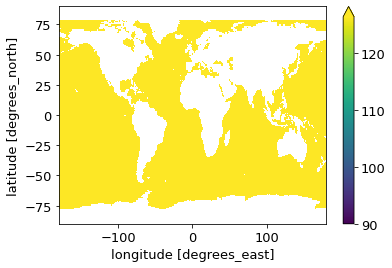

In [16]:
L.mean('mode').plot(vmax=100)

In [27]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 13

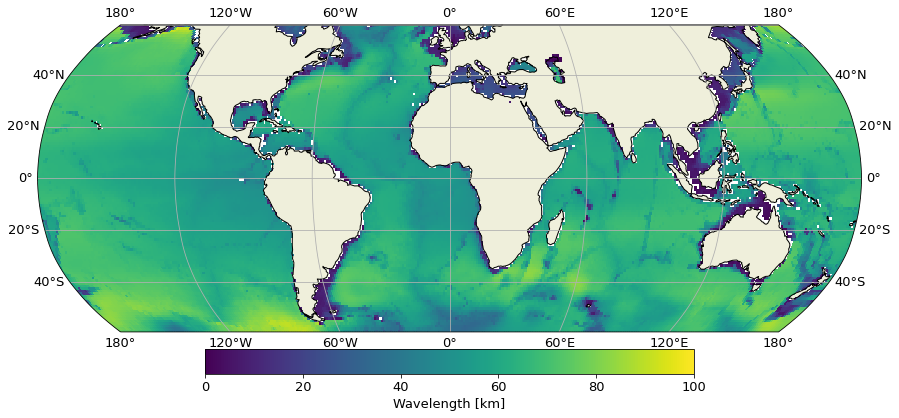

In [28]:
kwargs = {'orientation':'horizontal','fraction':0.07,'pad':0.05,'label':r'Wavelength [km]'}
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(L.sel(mode=slice(1,5)).mean('mode').sel(lat_bins=slice(-60,60)),
                   colmap='viridis',vlim=(0,100),**kwargs)
#ax.set_title(r'$<\vert\tilde{u}_L\vert^2>_{t,b}/<[\vert\tilde{u}_E\vert^2]_t>_b$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/kestimate_woa.png',bbox_inches='tight')

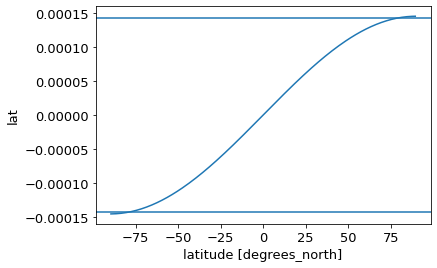

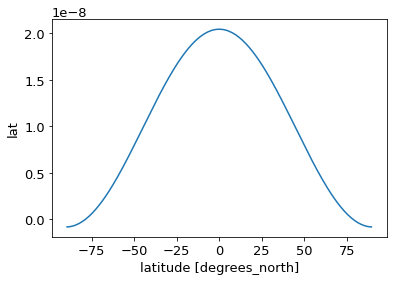

In [29]:
#L.sel(mode=slice(0,3)).mean('mode').plot(vmax=100)

plt.figure()
f.plot()
plt.axhline(rad*omega/day2sec)
plt.axhline(-rad*omega/day2sec)

plt.figure()
((rad*omega/day2sec)**2-f**2).plot()

In [53]:
# wave
#omega = omega_sn#(omega_S2+omega_M2)/2 # cpd
T = np.nanmean(Te) # days
L = np.arange(10e3,500e3,10e3)
#k = 2*np.pi/L # rad/m
#k = 2*np.pi/100e3 # rad/m
k = (["lon","lat"],k.sel(mode=slice(1,5)).mean('mode').sel(lat=slice(-60,60)).values[:-2:2,:-2:2].T)
# filter
bandwidth = 0.4 # cpd

In [54]:
dsL_low_mean1

<xarray.Dataset>
Dimensions:         (lat_bin: 59, lon_bin: 179, param: 2, lags: 321)
Coordinates:
  * lat_bin         (lat_bin) float64 -59.0 -57.0 -55.0 -53.0 ... 53.0 55.0 57.0
  * lon_bin         (lon_bin) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * param           (param) object 'T' 'V'
  * lags            (lags) float64 0.0 0.125 0.25 0.375 ... 39.75 39.88 40.0
Data variables:
    parameters_SSU  (lat_bin, lon_bin, param) float64 nan nan ... 1.515 0.01513
    error_SSU       (lat_bin, lon_bin, param) float64 nan nan ... 39.1 0.2651
    rr_SSU          (lat_bin, lon_bin, lags) float64 ...
    parameters_SSV  (lat_bin, lon_bin, param) float64 nan nan ... 1.549 0.01262
    error_SSV       (lat_bin, lon_bin, param) float64 nan nan ... 47.43 0.2626
    rr_SSV          (lat_bin, lon_bin, lags) float64 ...

In [54]:
plt.contourf(dsL_low_mean1.lon_bin.values,dsL_low_mean1.lat_bin.values,2*np.pi/(k[1].T)*1e-3,
             levels = 50,vmax=100)
plt.colorbar()

TypeError: 'float' object is not subscriptable

In [68]:
ds = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ulbar)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U)))
#ds = xr.Dataset(dict(T=(["lon",'lat'],Tl.T), k=k, Ubar=(["lon",'lat'], np.sqrt(Ulbar)),
#                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U)))
ds = ds.chunk({"lon":10,'lat':10})

T = np.nanmean(TeV) # days
dsV = xr.Dataset(dict(T=(["lon",'lat'],TlV.T), k=k, Ubar=(["lon",'lat'], np.sqrt(Vlbar)),
                     Tbar=(["lon",'lat'], TlbarV.T), U=(["lon",'lat'], V)))
dsV = dsV.chunk({"lon":10,'lat':10})
#ds_V = xr.Dataset(dict(T=(["lon",'lat'],Te_SSV), k=k, Ubar=(["lon",'lat'], np.sqrt(Ubar_SSV)),
#                     Tbar=(["lon",'lat'], Tlbar_SSV.T), U=(["lon",'lat'], U_SSV)))

TypeError: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property.

In [56]:
#Ee,El,ratio = get_lagrangian_energy_loss([omega_sn,omega_sn], bandwidth, ds, U=ds.U, _factor_tau_max=10,axis=-1)
#Ee_V,El_V,ratio_V = get_lagrangian_energy_loss([omega_sn,omega_sn], bandwidth, dsV, U=ds.U, _factor_tau_max=10,axis=-1)

Ee,El,ratio = get_eulerian_energy([omega_sn,omega_sn], bandwidth, ds, U=ds.U, _factor_tau_max=10,axis=-1)
Ee_V,El_V,ratio_V = get_eulerian_energy([omega_sn,omega_sn], bandwidth, dsV, U=ds.U, _factor_tau_max=10,axis=-1)

['tau'] ['omega']
['tau'] ['omega']


In [57]:
El = El.compute()
Ee = Ee.compute()
ratio = El/Ee

In [58]:
Ee#.plot(vmax=0.001)

<xarray.DataArray 'Ee' (lon: 179, lat: 59)>
array([[            nan,             nan,             nan, ...,
                    nan,  2.48705532e-02, -6.54146238e+07],
       [            nan,             nan,             nan, ...,
                    nan, -5.18429964e+20,  6.43322925e+00],
       [            nan,             nan,             nan, ...,
                    nan,  2.08263931e-02, -2.01422850e+82],
       ...,
       [            nan,             nan,             nan, ...,
                    nan, -1.66359691e+06,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,  1.93096050e-01],
       [            nan,             nan,             nan, ...,
                    nan,             nan,  1.02443383e+61]])
Coordinates:
    T        (lon, lat) float64 nan 19.34 2.585 2.136 ... 2.893 2.883 10.46
    k        (lon, lat) float32 0.000113 0.0001097 ... 0.0001153 0.0001115
    Ubar     (lon, lat) float64 0.1195 0.2037 0.3504 ... 0.1704 0.1299 0.1297
    Tbar     (lon, lat) float64 nan 1.282 4.14 1.547 ... 2.767 1.419 1.64 1.515
Dimensions without coordinates: lon, lat

In [59]:
El_V = El_V.compute()
Ee_V = Ee_V.compute()
ratio_V = El_V/Ee_V

In [60]:
ds_predict = xr.Dataset({'Ee':Ee,'El':El,'ratio':ratio})#,compat='override')
#ds_predict_SSV = xr.Dataset({'Ee':Ee_SSV,'El':El_SSV,'ratio':ratio_SSV})

ds_predict = ds_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict = ds_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

In [61]:
dsV_predict = xr.Dataset({'Ee':Ee_V,'El':El_V,'ratio':ratio_V})#,compat='override')
#ds_predict_SSV = xr.Dataset({'Ee':Ee_SSV,'El':El_SSV,'ratio':ratio_SSV})

dsV_predict = dsV_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
dsV_predict = dsV_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

Text(0.5, 1.0, 'Eulerian estimation ratio')

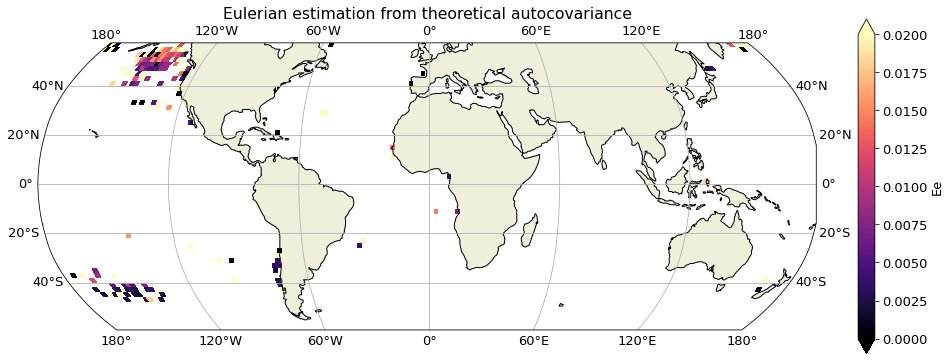

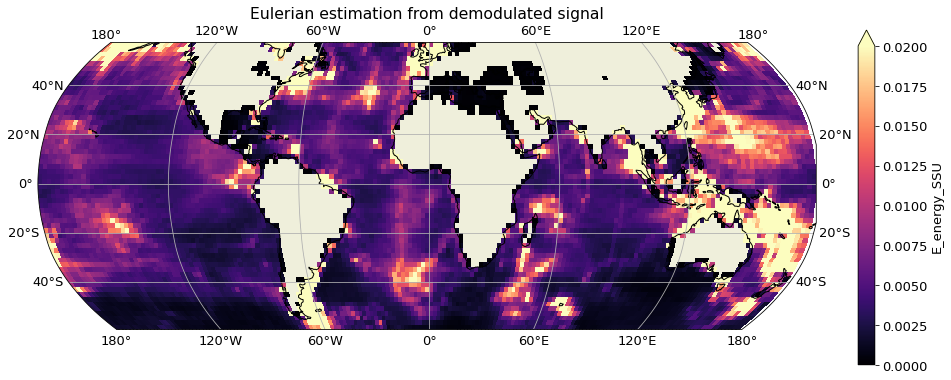

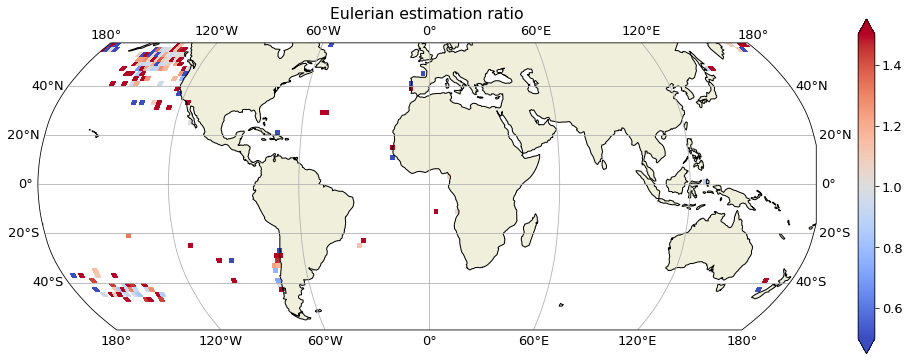

In [62]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee,colmap='magma',vlim=(0,0.02))
ax.set_title('Eulerian estimation from theoretical autocovariance')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(hf_dl2.E_energy_SSU,colmap='magma',vlim=(0,0.02))
ax.set_title('Eulerian estimation from demodulated signal')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Eulerian estimation ratio')

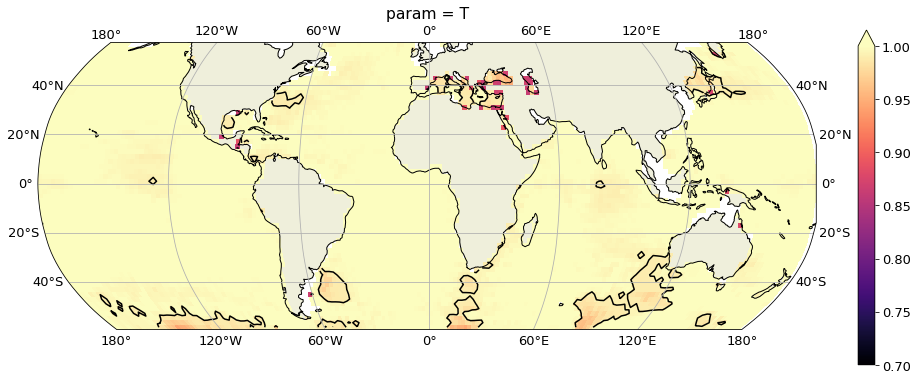

In [53]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee/hf_dl2.E_energy_SSU,colmap='magma',vlim=(0.7,1.))
ax.set_title('Eulerian estimation ratio')
dsE.sel(param='T').parameters_SSU.plot.contour(levels=[10],ax=ax,colors='k',
                                               transform=ccrs.PlateCarree(),y='lat_bins')

Text(0.5, 1.0, 'Lagrangian estimation ratio')

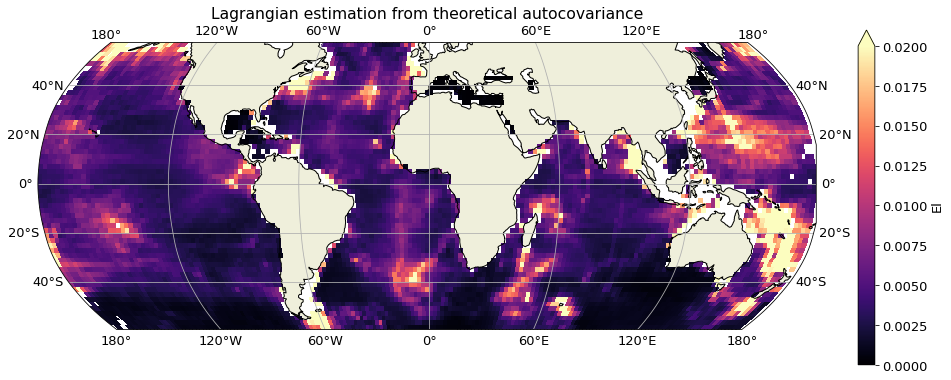

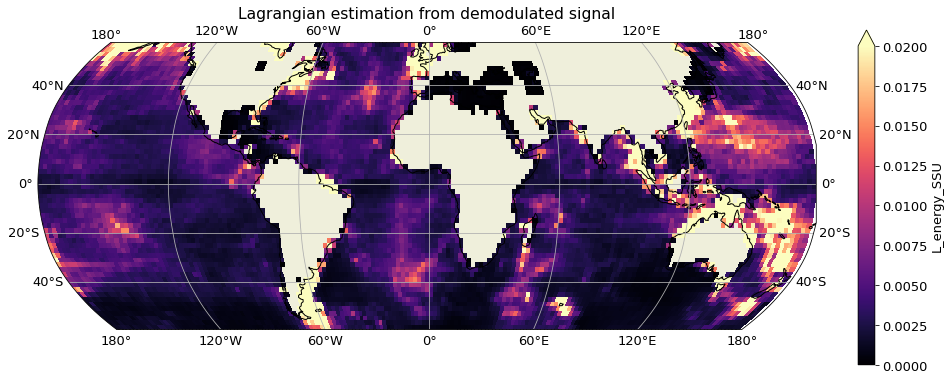

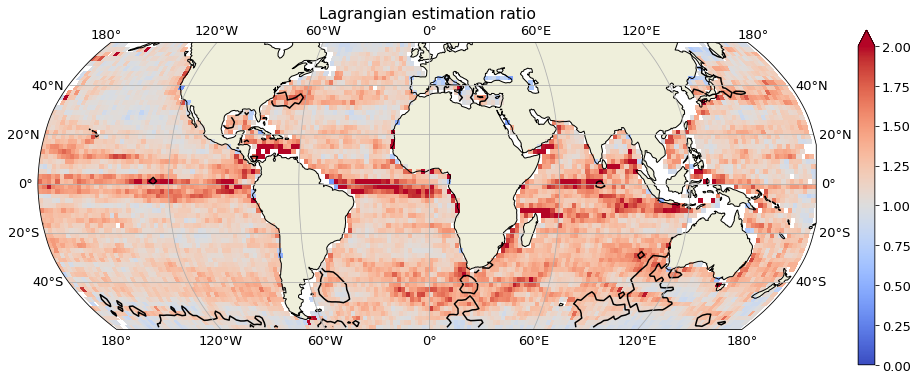

In [54]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.El,colmap='magma',vlim=(0,0.02))
ax.set_title('Lagrangian estimation from theoretical autocovariance')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(hf_dl2.L_energy_SSU,colmap='magma',vlim=(0,0.02))
ax.set_title('Lagrangian estimation from demodulated signal')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.El/hf_dl2.L_energy_SSU,colmap='coolwarm',vlim=(0,2))
dsE.sel(param='T').parameters_SSU.plot.contour(levels=[10],ax=ax,colors='k',
                                               transform=ccrs.PlateCarree(),y='lat_bins')

ax.set_title('Lagrangian estimation ratio')

In [55]:
hf_dl2 = hf_dl2.where(hf_dl2.waterdepth>500)

In [56]:
kwargs = {'orientation':'horizontal','fraction':0.07,'pad':0.05,'label':r''}



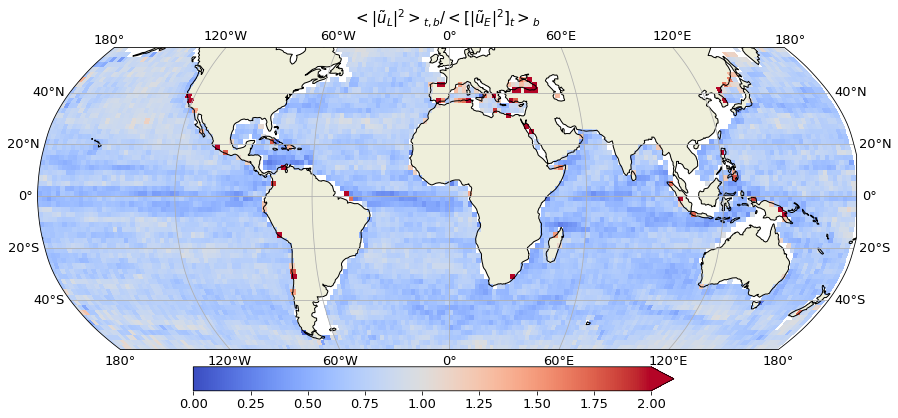

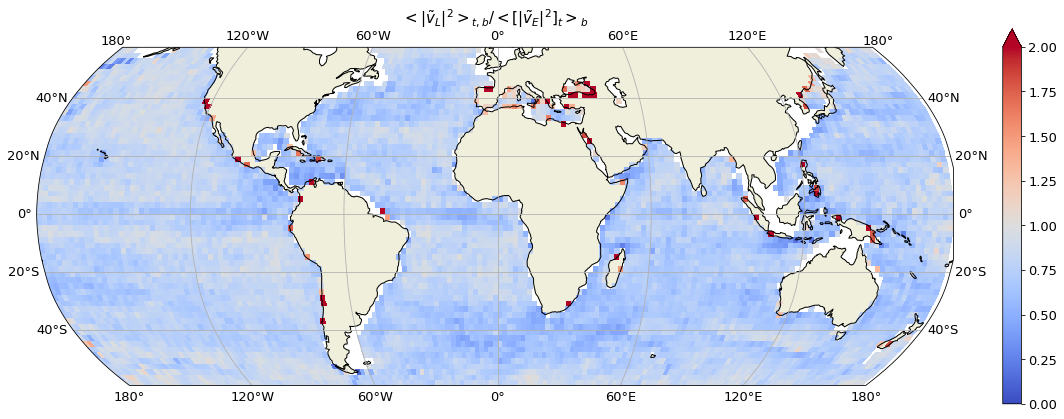

In [57]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0,2),**kwargs)
ax.set_title(r'$<\vert\tilde{u}_L\vert^2>_{t,b}/<[\vert\tilde{u}_E\vert^2]_t>_b$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/ratio_SSU.png',bbox_inches='tight')
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(hf_dl2.L_energy_SSV/hf_dl2.E_energy_SSV,colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$<\vert\tilde{v}_L\vert^2>_{t,b}/<[\vert\tilde{v}_E\vert^2]_t>_b$',size=15)
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/ratio_SSV.png',bbox_inches='tight')

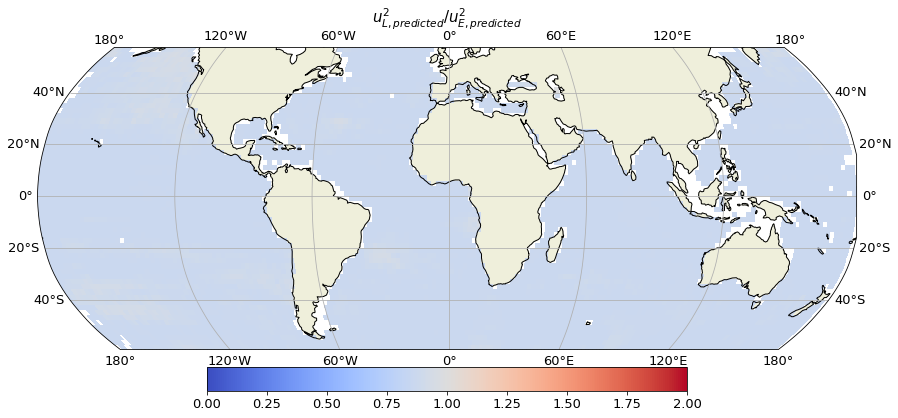

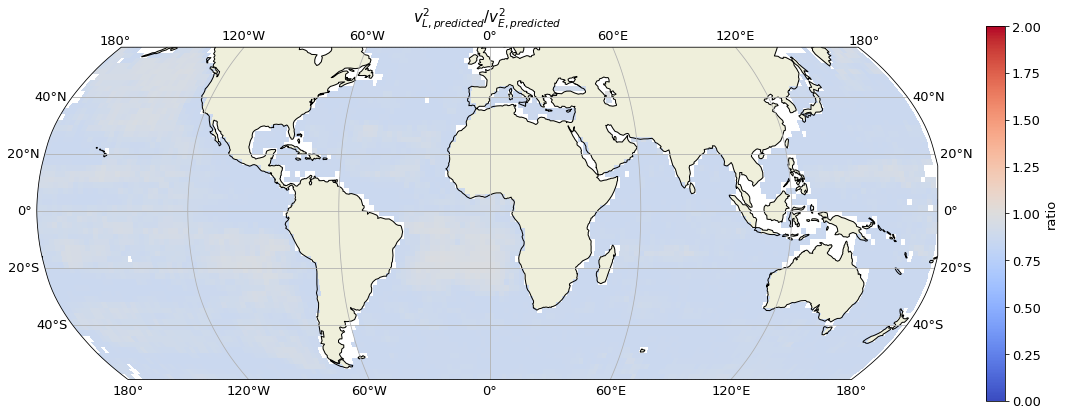

In [58]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_predict.ratio,colmap='coolwarm',vlim=(0,2),**kwargs)
ax.set_title(r'$u_{L,predicted}^2/u_{E,predicted}^2$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/predicted_ratio_SSU.png',bbox_inches='tight')
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(dsV_predict.ratio,colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$v_{L,predicted}^2/v_{E,predicted}^2$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/predicted_ratio_SSV.png',bbox_inches='tight')

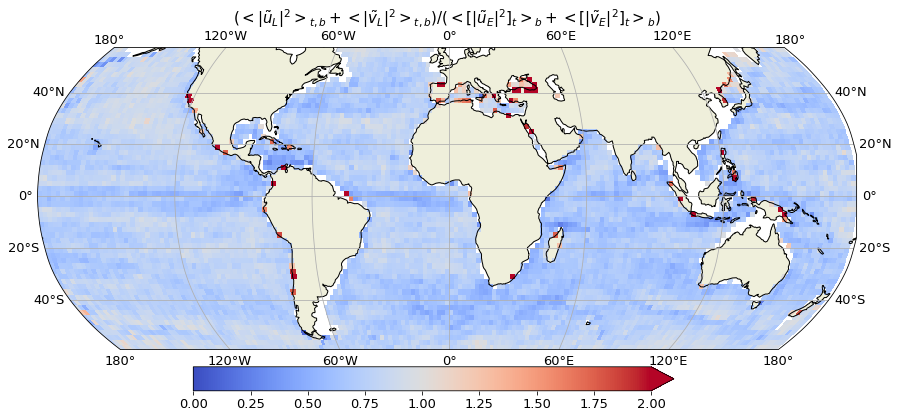

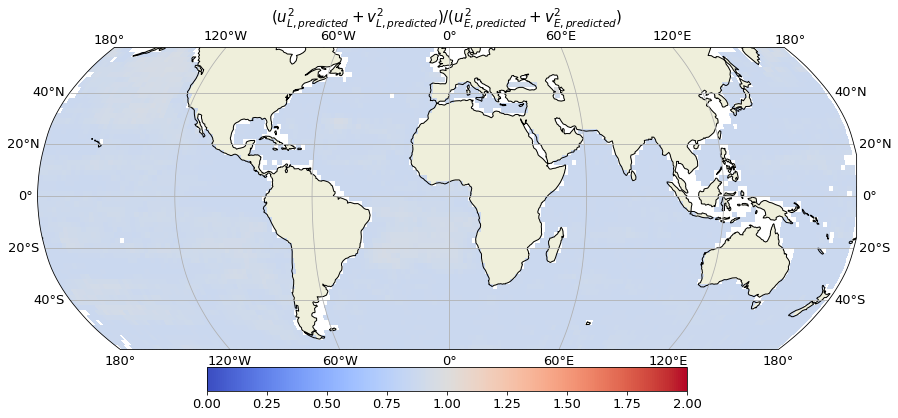

In [59]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps((hf_dl2.L_energy_SSU+hf_dl2.L_energy_SSV)/(hf_dl2.E_energy_SSU+hf_dl2.E_energy_SSV),colmap='coolwarm',vlim=(0,2),**kwargs)
ax.set_title(r'$(<\vert\tilde{u}_L\vert^2>_{t,b}+<\vert\tilde{v}_L\vert^2>_{t,b})/(<[\vert\tilde{u}_E\vert^2]_t>_b+<[\vert\tilde{v}_E\vert^2]_t>_b)$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/ratio.png',bbox_inches='tight')

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps((ds_predict.El+dsV_predict.El)/(ds_predict.Ee+dsV_predict.Ee),colmap='coolwarm',vlim=(0,2),**kwargs)
ax.set_title(r'$(u_{L,predicted}^2+v_{L,predicted}^2)/(u_{E,predicted}^2+v_{E,predicted}^2)$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/predicted_ratio.png',bbox_inches='tight')

In [29]:
import seaborn as sns
Tl = (ds_predict.El+dsV_predict.El)/(ds_predict.Ee+dsV_predict.Ee)
Te = (hf_dl2.L_energy_SSU+hf_dl2.L_energy_SSV)/(hf_dl2.E_energy_SSU+hf_dl2.E_energy_SSV)

In [ ]:

#sns.jointplot(x=Te.values.flatten(),y=Tl.values.flatten(),kind='kde',xlim=(2,100),ylim=(2,100))
axs = sns.jointplot(x=Te.values.flatten(),y=Tl.values.flatten(),kind='hist',xlim=(0.2,1),ylim=(0.2,1))
axs.set_axis_labels('Energy ratio (observed)',r'Energy ratio (predicted)');
for ax in (axs.ax_joint, axs.ax_marg_y):
    ax.axhline(axs.y.mean(),c='k',ls='--')
for ax in (axs.ax_joint, axs.ax_marg_x):
    ax.axvline(axs.x.mean(),c='k',ls='--')
#axs.grid()
fig = axs.fig
fig.tight_layout()
fig.savefig(fig_dir+'LE_predicted_jointpdf.png')

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x13914e3d0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/croco/lib/python3.8/site-packages/distributed/utils_perf.py", line 182, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


Error in callback <function flush_figures at 0x13ce549d0> (for post_execute):


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [154]:
ds_predicted = get_lagrangian_energy_loss(omega, bandwidth, ds, U=ds.U, _factor_tau_max=10,axis=-1,full_output=True)
dsV_predicted = get_lagrangian_energy_loss(omega, bandwidth, dsV, U=ds.U, _factor_tau_max=10,axis=-1,full_output=True)

['tau'] ['omega']
['tau'] ['omega']


In [156]:
ds_predicted = ds_predicted.compute()
dsV_predicted = dsV_predicted.compute().assign_coords({'lon_bins':dsE.lon_bins.values,
                                                       'lat_bins':dsE.lat_bins.values})

In [158]:
ds_predicted = ds_predicted.assign_coords({'lon':dsE.lon_bins.values,'lat':dsE.lat_bins.values})
dsV_predicted = dsV_predicted.assign_coords({'lon':dsE.lon_bins.values,'lat':dsE.lat_bins.values})

In [160]:
ds_predicted = ds_predicted.drop(['lon_bins','lat_bins'])
dsV_predicted = dsV_predicted.drop(['lon_bins','lat_bins'])

In [161]:
ds_predicted.to_netcdf(root_path+'ds_predicted.nc')
dsV_predicted.to_netcdf(root_path+'dsV_predicted.nc')

In [18]:
# wave
omega = (omega_S2+omega_M2)/2 # cpd
T = np.nanmean(Te) # days
L = np.arange(1e3,1000e3,10e3)
k = 2*np.pi/L # rad/m


# filter
bandwidth = 0.4 # cpd
ds = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ulbar)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U)))
ds = ds.chunk({"lon":10,'lat':10,'k':-1})
dsV = xr.Dataset(dict(T=(["lon",'lat'],TeV), k=k, Ubar=(["lon",'lat'], np.sqrt(Vlbar)),
                     Tbar=(["lon",'lat'], TlbarV.T), U=(["lon",'lat'], V)))
dsV = dsV.chunk({"lon":10,'lat':10,'k':-1})
ds

<xarray.Dataset>
Dimensions:  (lon: 179, lat: 59, k: 100)
Coordinates:
  * k        (k) float64 0.006283 0.0005712 0.0002992 ... 6.405e-06 6.34e-06
Dimensions without coordinates: lon, lat
Data variables:
    T        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Ubar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Tbar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    U        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>

In [19]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, U=ds.U, _factor_tau_max=10,axis=-1)
T = np.nanmean(TeV) # days
Ee_V,El_V,ratio_V = get_lagrangian_energy_loss(omega, bandwidth, dsV, U=dsV.U, _factor_tau_max=10,axis=-1)

['tau'] ['omega']
['tau'] ['omega']


In [20]:
El = El.compute()
Ee = Ee.compute()
ratio = El/Ee

In [21]:
El_V = El_V.compute()
Ee_V = Ee_V.compute()
ratio_V = El_V/Ee_V

In [22]:
ds_predict = xr.Dataset({'Ee':Ee,'El':El,'ratio':ratio})
#ds_predict_SSV = xr.Dataset({'Ee':Ee_SSV,'El':El_SSV,'ratio':ratio_SSV})

ds_predict = ds_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict = ds_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})
ds_predict

<xarray.Dataset>
Dimensions:   (lon_bins: 179, lat_bins: 59, k: 100)
Coordinates:
    T         (lon_bins, lat_bins) float64 17.33 19.92 18.8 ... 46.49 28.4 46.25
    Ubar      (lon_bins, lat_bins) float64 0.1195 0.2037 ... 0.1299 0.1297
    Tbar      (lon_bins, lat_bins) float64 nan 4.135 3.261 ... 2.209 1.659 1.498
  * k         (k) float64 0.006283 0.0005712 0.0002992 ... 6.405e-06 6.34e-06
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
Data variables:
    Ee        (lon_bins, lat_bins) float64 0.001601 0.001412 ... 0.02003 0.019
    El        (lon_bins, lat_bins, k) float64 nan nan nan ... 0.01899 0.01899
    ratio     (lon_bins, lat_bins, k) float64 nan nan nan ... 0.9997 0.9997

In [23]:
dsV_predict = xr.Dataset({'Ee':Ee_V,'El':El_V,'ratio':ratio_V})#,compat='override')
#ds_predict_SSV = xr.Dataset({'Ee':Ee_SSV,'El':El_SSV,'ratio':ratio_SSV})

dsV_predict = dsV_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
dsV_predict = dsV_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

In [24]:
El_true = hf_dl2.L_energy_SSU
ElV_true = hf_dl2.L_energy_SSV

In [25]:
id_min = np.abs(ds_predict.El-El_true).idxmin('k',skipna=False)
id_minV = np.abs(dsV_predict.El-ElV_true).idxmin('k',skipna=False)
#ds_predict.k#.isel(k=np.abs(ds_predict.El-El_true).argmin('k',skipna=False).values)
#.plot(y='lat_bins')

In [36]:
id_minV.to_netcdf('/home1/datawork/zcaspar/mit4320/k_estimateV.nc')

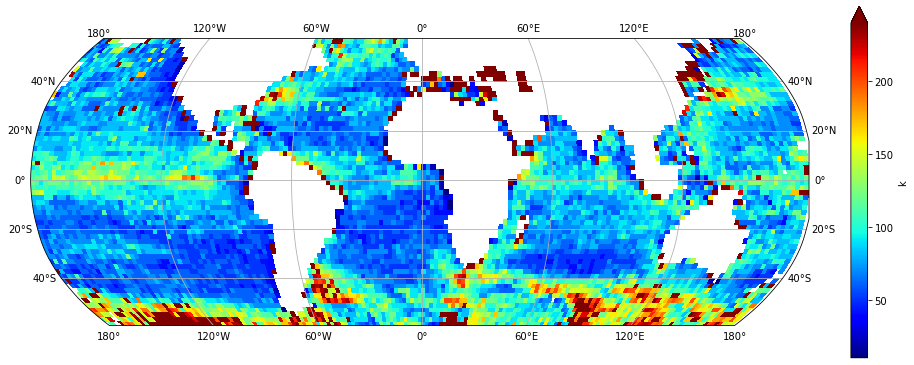

In [27]:
#.plot(y='lat_bins')
id_min = id_min.where(2*np.pi/id_min*1e-3>1)
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((2*np.pi/id_min*1e-3),colmap='jet',vlim=(10,240))

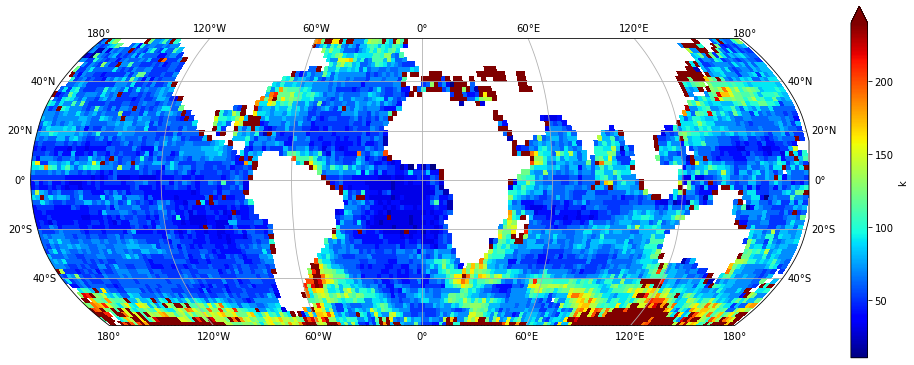

In [28]:
id_minV = id_minV.where(2*np.pi/id_minV*1e-3>1)
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((2*np.pi/id_minV*1e-3),colmap='jet',vlim=(10,240))

In [60]:
# wave
omega = (omega_S2+omega_M2)/2 # cpd
T = np.nanmean(Te) # days
k = xr.open_dataset(root_path+'k_estimate.nc') # rad/m
kV = xr.open_dataset(root_path+'k_estimateV.nc') # rad/m


# filter
bandwidth = 0.4 # cpd
ds = xr.Dataset(dict(T=(["lon",'lat'],Te), k=(["lon",'lat'],k.k.values), Ubar=(["lon",'lat'], np.sqrt(Ulbar)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U)))
ds = ds.chunk({"lon":10,'lat':10})


ds

<xarray.Dataset>
Dimensions:  (lon: 179, lat: 59)
Dimensions without coordinates: lon, lat
Data variables:
    T        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    k        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Ubar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Tbar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    U        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>

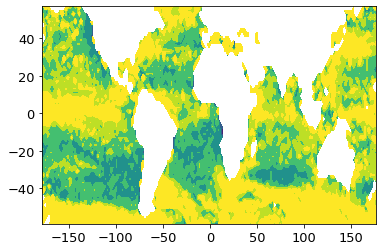

In [37]:
plt.contourf(dsL_low_mean1.lon_bin.values,dsL_low_mean1.lat_bin.values,(2*np.pi/ds.k.values*1e-3).T,
             levels=50,vmax=100,vmin=0)


In [14]:
def energy_loss_wrapper(ds,omega,bandwidth,T):
    T = T
    Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, U=ds.U, _factor_tau_max=10,axis=-1)
    El = El.compute()
    Ee = Ee.compute()
    ratio = El/Ee
    ds_predict = xr.Dataset({'Ee':Ee,'El':El,'ratio':ratio})
    ds_predict = ds_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
    ds_predict = ds_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})
    return ds_predict

In [15]:
ds_predict = energy_loss_wrapper(ds,omega,bandwidth,Te)

['tau'] ['omega']


In [16]:
ds_predict

<xarray.Dataset>
Dimensions:   (lon_bins: 179, lat_bins: 59)
Coordinates:
    T         (lon_bins, lat_bins) float64 15.63 18.02 16.64 ... 26.02 54.44
    k         (lon_bins, lat_bins) float64 nan 5.661e-05 ... 7.757e-05 4.796e-05
    Ubar      (lon_bins, lat_bins) float64 0.1195 0.2037 ... 0.1299 0.1297
    Tbar      (lon_bins, lat_bins) float64 nan 4.135 3.261 ... 2.209 1.659 1.498
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
Data variables:
    Ee        (lon_bins, lat_bins) float64 0.001596 0.001408 ... 0.02 0.01903
    El        (lon_bins, lat_bins) float64 nan 0.001136 ... 0.0176 0.01846
    ratio     (lon_bins, lat_bins) float64 nan 0.8073 0.8118 ... 0.8801 0.9698

In [17]:
dsV = xr.Dataset(dict(T=(["lon",'lat'],TeV), k=(["lon",'lat'],kV.k.values), Ubar=(["lon",'lat'], np.sqrt(Vlbar)),
                     Tbar=(["lon",'lat'], TlbarV.T), U=(["lon",'lat'], V)))
dsV = dsV.chunk({"lon":10,'lat':10})
dsV

<xarray.Dataset>
Dimensions:  (lon: 179, lat: 59)
Dimensions without coordinates: lon, lat
Data variables:
    T        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    k        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Ubar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Tbar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    U        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>

In [18]:
dsV_predict = energy_loss_wrapper(dsV,omega,bandwidth,TeV)

['tau'] ['omega']


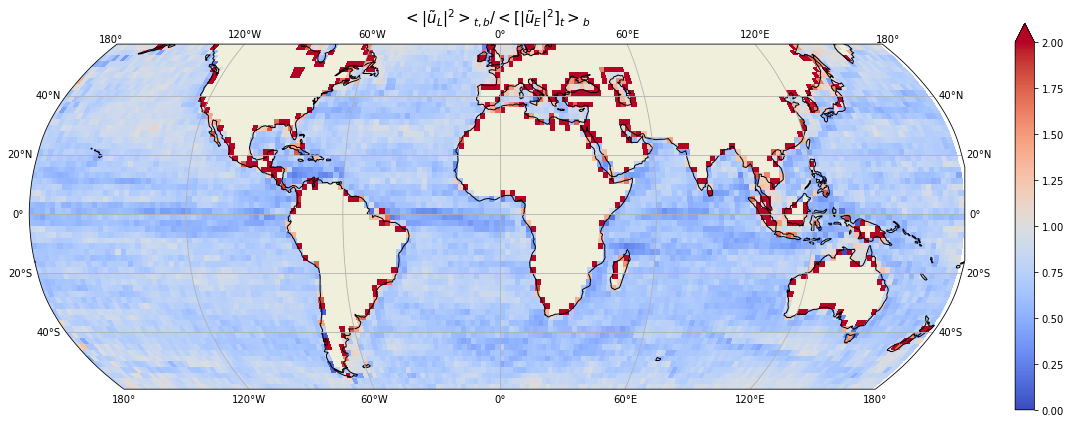

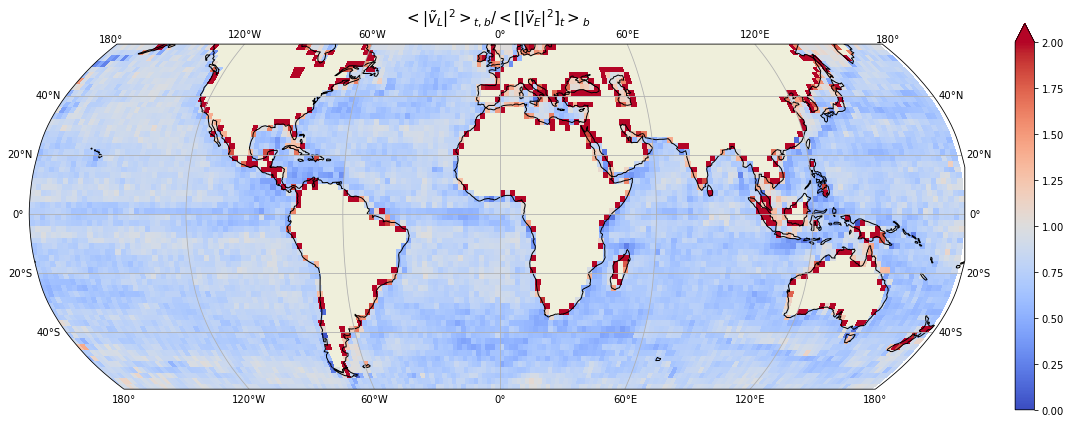

In [26]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$<\vert\tilde{u}_L\vert^2>_{t,b}/<[\vert\tilde{u}_E\vert^2]_t>_b$',size=15)
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/ratio_kestimate_SSU.png',bbox_inches='tight')
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(hf_dl2.L_energy_SSV/hf_dl2.E_energy_SSV,colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$<\vert\tilde{v}_L\vert^2>_{t,b}/<[\vert\tilde{v}_E\vert^2]_t>_b$',size=15)
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/ratio_kestimate_SSV.png',bbox_inches='tight')

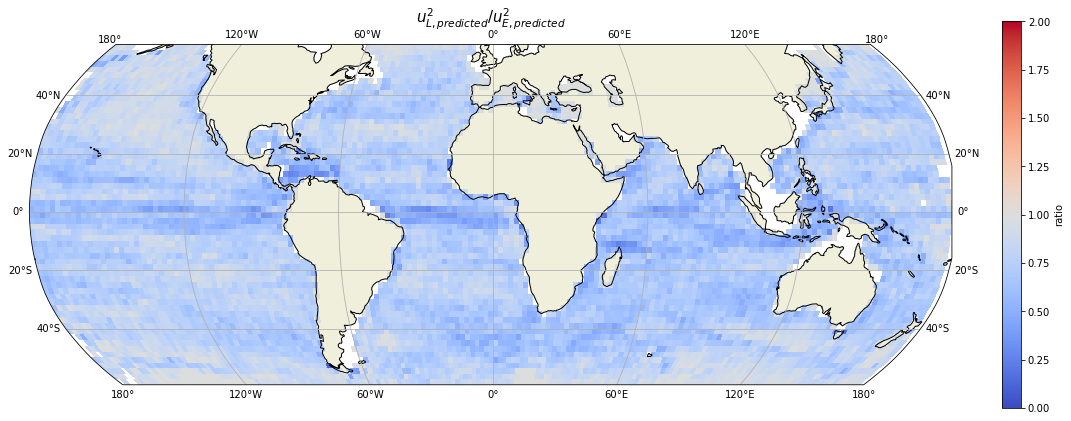

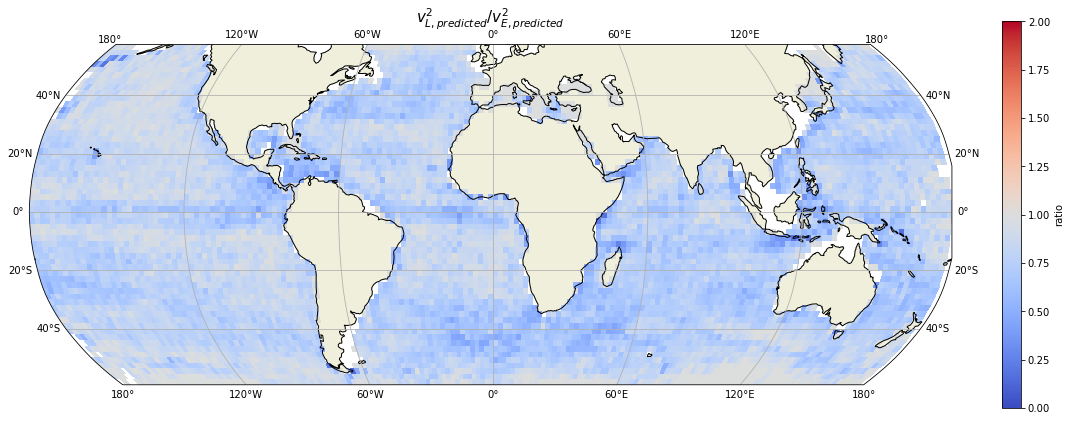

In [27]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_predict.ratio,colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$u_{L,predicted}^2/u_{E,predicted}^2$',size=15)
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/predicted_ratio_kestimate_SSU.png',bbox_inches='tight')
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(dsV_predict.ratio,colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$v_{L,predicted}^2/v_{E,predicted}^2$',size=15)
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/predicted_ratio_kestimate_SSV.png',bbox_inches='tight')

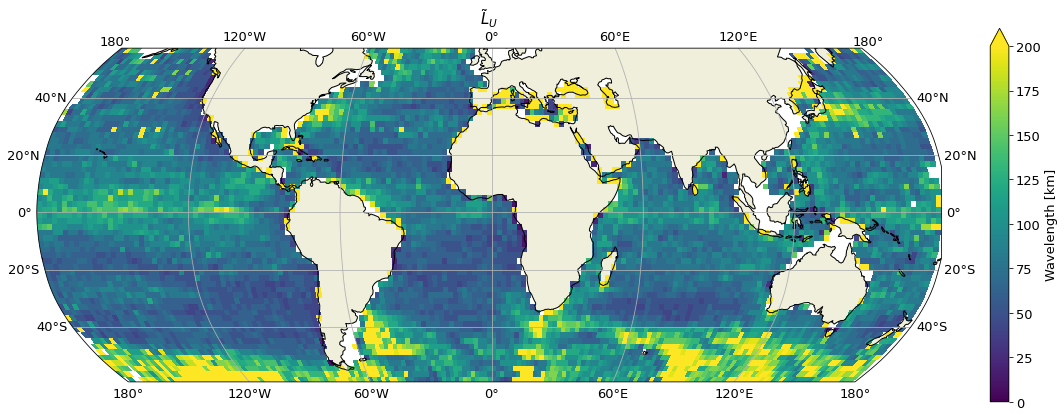

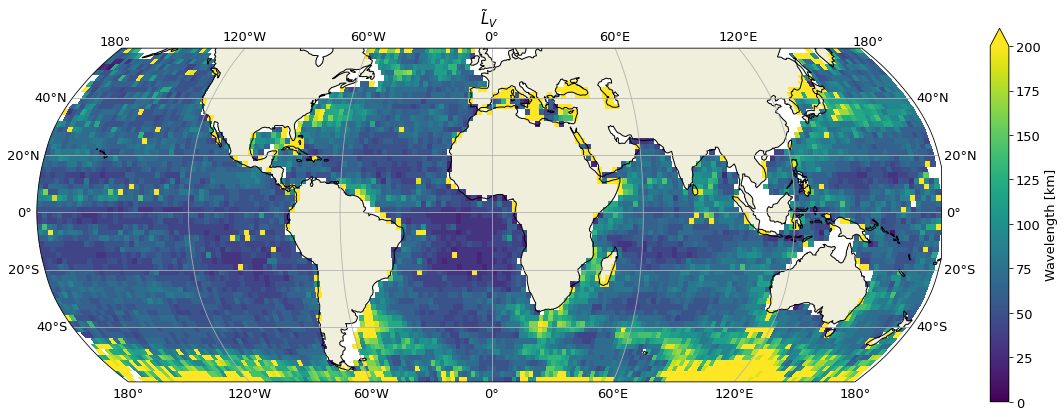

In [67]:
kwargs = {'label':r'Wavelength [km]'}

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(2*np.pi*1e-3/k.k,colmap='viridis',vlim=(0,200),**kwargs)
ax.set_title(r'$\tilde L_U$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/kestimate_SSU.png',bbox_inches='tight')

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(2*np.pi*1e-3/kV.k,colmap='viridis',vlim=(0,200),**kwargs)
ax.set_title(r'$\tilde L_V$',size=15)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/kestimate_SSV.png',bbox_inches='tight')

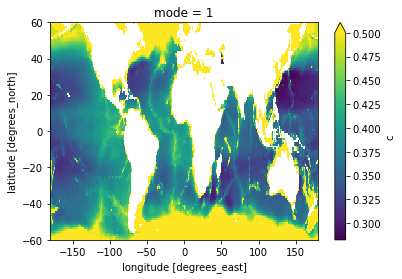

In [77]:
(1/vmodes.c.sel(mode=1)).plot(vmax = 0.5,ylim=(-60,60))

In [83]:
(rad*omega/day2sec)**2/(vmodes.c)**2

<xarray.DataArray 'c' (lat: 180, lon: 360, mode: 6)>
array([[[           nan,            nan,            nan,            nan,
                    nan,            nan],
        [           nan,            nan,            nan,            nan,
                    nan,            nan],
        [           nan,            nan,            nan,            nan,
                    nan,            nan],
        ...,
        [           nan,            nan,            nan,            nan,
                    nan,            nan],
        [           nan,            nan,            nan,            nan,
                    nan,            nan],
        [           nan,            nan,            nan,            nan,
                    nan,            nan]],

       [[           nan,            nan,            nan,            nan,
                    nan,            nan],
        [           nan,            nan,            nan,            nan,
                    nan,            nan],
        [           nan,            nan,            nan,            nan,
                    nan,            nan],
...
        [5.32425449e-13, 1.12377663e-08, 3.04010364e-08, 7.86332279e-08,
         1.49300263e-07, 2.11518113e-07],
        [5.32426154e-13, 1.12021068e-08, 3.03108330e-08, 7.83512561e-08,
         1.49129207e-07, 2.11692125e-07],
        [5.32427834e-13, 1.11678116e-08, 3.03277119e-08, 7.82799248e-08,
         1.49110434e-07, 2.11421394e-07]],

       [[4.94573783e-13, 1.16868257e-08, 3.11026973e-08, 8.20430657e-08,
         1.50714953e-07, 2.15599130e-07],
        [4.94573783e-13, 1.16868257e-08, 3.11026973e-08, 8.20430657e-08,
         1.50714953e-07, 2.15599130e-07],
        [4.94573783e-13, 1.16868257e-08, 3.11026973e-08, 8.20430657e-08,
         1.50714953e-07, 2.15599130e-07],
        ...,
        [4.83070235e-13, 1.16543095e-08, 3.08263175e-08, 8.16975145e-08,
         1.48651353e-07, 2.13398636e-07],
        [4.83070235e-13, 1.16543095e-08, 3.08263175e-08, 8.16975145e-08,
         1.48651353e-07, 2.13398636e-07],
        [4.94573783e-13, 1.16868257e-08, 3.11026973e-08, 8.20430657e-08,
         1.50714953e-07, 2.15599130e-07]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * mode     (mode) int64 0 1 2 3 4 5

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


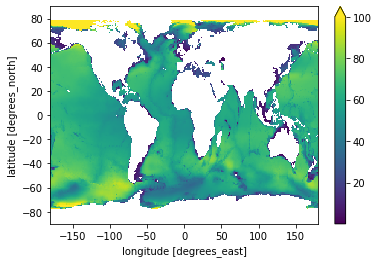

In [103]:
L.isel(mode=slice(1,None)).mean('mode').plot(vmax=100)

#### Tapp

In [14]:
sigma = lambda ds : (ds['Tb']*day2sec*ds['Ub'])*np.sqrt(2*(ds['tau']/ds['Tb'] - (1-np.exp(-np.abs(ds['tau']/ds['Tb'])))))

In [15]:
day2sec = 3600*24
t = np.arange(0,500*day2sec,6*3600)

In [16]:
ds = xr.Dataset(dict(k=k.k, Ub=(["lon_bins",'lat_bins'], np.sqrt(Ulbar)),
                     Tb=(["lon_bins",'lat_bins'], Tlbar.T),tau=(['lag'],t))).assign_coords({'lag':t})

In [82]:
ds

<xarray.Dataset>
Dimensions:   (lon_bins: 179, lat_bins: 59, lag: 2000)
Coordinates:
    T         (lon_bins, lat_bins) float64 17.33 19.92 18.8 ... 46.49 28.4 46.25
    Ubar      (lon_bins, lat_bins) float64 0.1195 0.2037 ... 0.1299 0.1297
    Tbar      (lon_bins, lat_bins) float64 nan 4.135 3.261 ... 2.209 1.659 1.498
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lag       (lag) int64 0 21600 43200 64800 ... 43135200 43156800 43178400
Data variables:
    k         (lon_bins, lat_bins) float64 nan 5.661e-05 ... 7.757e-05 4.796e-05
    Ub        (lon_bins, lat_bins) float64 0.1195 0.2037 ... 0.1299 0.1297
    Tb        (lon_bins, lat_bins) float64 nan 4.135 3.261 ... 2.209 1.659 1.498
    tau       (lag) int64 0 21600 43200 64800 ... 43135200 43156800 43178400

In [19]:
ksig = ds['k']*sigma(ds)

In [20]:
id_min = np.abs(ksig-1).idxmin('lag',skipna=False)

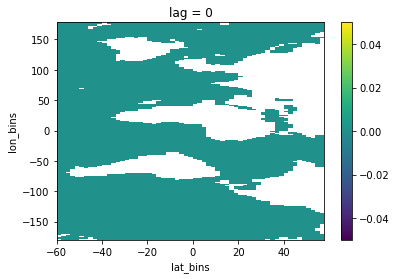

In [79]:
ksig.sel(lag=0).plot()

#### $\tilde T_L$ estimation 

In [21]:
Tl_v1 = 2*np.pi/(k.k*Ulbar)/day2sec
Tl_v2 = (2*np.pi)**2/((k.k*Ulbar)**2*Tlbar.T*day2sec)

In [22]:
Tl_v2

<xarray.DataArray 'k' (lon_bins: 179, lat_bins: 59)>
array([[           nan, 2.00159060e+07, 8.58603028e+06, ...,
        2.24324479e+07, 1.97139010e+08, 3.62556949e+08],
       [8.91064326e+06, 1.90755691e+07, 4.54402164e+06, ...,
        3.96456730e+07, 3.87154217e+08, 2.96078797e+08],
       [           nan, 1.42555597e+07, 2.39812115e+06, ...,
        1.80832928e+07, 2.25168392e+08, 1.56692793e+10],
       ...,
       [4.13035795e+07, 1.04838964e+08, 9.07572776e+06, ...,
        7.30706340e+06, 1.51322267e+08, 7.75767131e+07],
       [8.43089548e+07, 4.28407782e+07, 2.25720775e+07, ...,
        1.86513250e+07, 1.45939572e+08, 5.28315679e+10],
       [8.20814867e+07, 2.32419719e+07, 1.84845517e+07, ...,
        2.31472926e+07, 1.60862732e+08, 4.69287018e+08]])
Coordinates:
    T         (lon_bins, lat_bins) float64 ...
    Ubar      (lon_bins, lat_bins) float64 ...
    Tbar      (lon_bins, lat_bins) float64 ...
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0

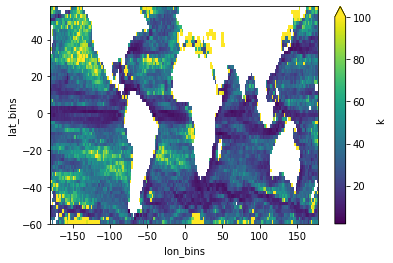

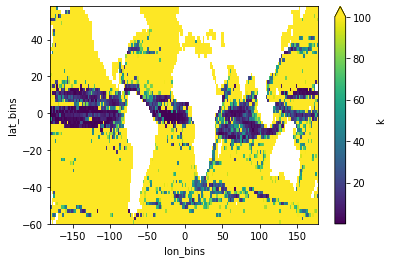

In [113]:
Tl_v1.plot(y='lat_bins',vmax=100)
plt.figure()
(Tl_v2/day2sec).plot(y='lat_bins',vmax=100)

In [145]:
omega_sn

0.03386319286637762

In [17]:
Ce = lambda ds : ds['U']*np.exp(-ds['tau']/ds['T'])*np.cos(rad*omega_sn*ds['tau'])
Cl = lambda ds : ds['Ce']*np.exp(-(ds['k']*sigma(ds)/(2*np.pi))**2)

In [18]:
ds = xr.Dataset(dict(k=k.k.drop(['T','Ubar','Tbar'])
                     , Ub=(["lon_bins",'lat_bins'], np.sqrt(Ulbar)),
                     Tb=(["lon_bins",'lat_bins'], Tlbar.T),
                     T=(['lon_bins','lat_bins'],Te), U=(["lon_bins",'lat_bins'], U)
                     ,tau = (['tau'],np.arange(0,40,1/24))
                    ))

In [19]:
ds['Ce'] = Ce(ds)
ds

<xarray.Dataset>
Dimensions:   (lon_bins: 179, lat_bins: 59, tau: 960)
Coordinates:
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * tau       (tau) float64 0.0 0.04167 0.08333 0.125 ... 39.88 39.92 39.96
Data variables:
    k         (lon_bins, lat_bins) float64 nan 5.661e-05 ... 7.757e-05 4.796e-05
    Ub        (lon_bins, lat_bins) float64 0.1195 0.2037 ... 0.1299 0.1297
    Tb        (lon_bins, lat_bins) float64 nan 4.135 3.261 ... 2.209 1.659 1.498
    T         (lon_bins, lat_bins) float64 15.63 18.02 16.64 ... 26.02 54.44
    U         (lon_bins, lat_bins) float64 0.001649 0.001448 ... 0.02039 0.01921
    Ce        (lon_bins, lat_bins, tau) float64 0.001649 0.001645 ... -0.005565

In [20]:
ds['Cl'] = Cl(ds)

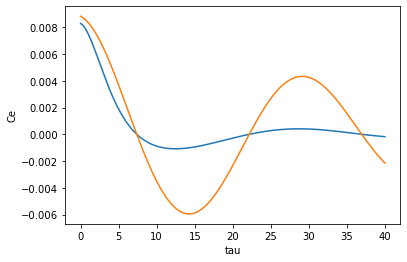

In [21]:
ds.Cl.mean(['lon_bins','lat_bins']).plot()
ds.Ce.mean(['lon_bins','lat_bins']).plot()

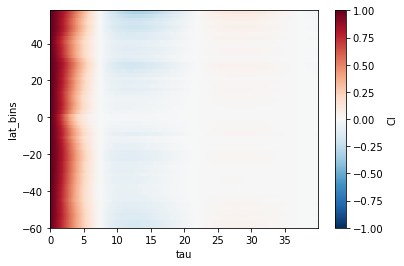

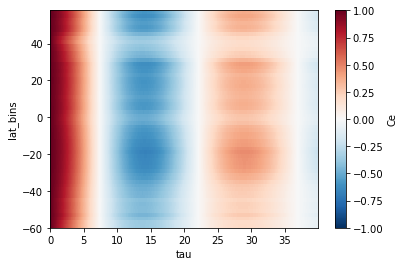

In [22]:
(ds.Cl/ds.Cl.isel(tau=0)).mean('lon_bins').plot()
plt.figure()
(ds.Ce/ds.Ce.isel(tau=0)).mean('lon_bins').plot()

In [23]:
def fit_function(y,t=None,myfunc=None,first_guess='free',bounds=None,sigma=None):
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        y : data to fit
        t : timelag of the correlation function
        myfunc : function we want to fit to our data, y
        p0 : first guess on parameters
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        params : parameters for which we obtain the best fit
        error : covariance of params computed in scipy.optimize.curve_fit
        yfit : best fit
        """
    sig = signature(myfunc)
    len_sig = len(sig.parameters.keys())
    try : 
        if first_guess=='lag' and sigma is None:
            _p0 = np.full(len_sig-1,1)
            _p0[-1] = y[0]
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000)
    #    try:
        if sigma is not None:
            if first_guess=='lag':
                _p0 = np.full(len_sig-1,1)
                _p0[-1] = y[0]
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
            else:
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
        else:
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000)
        yfit = myfunc(t,*[p for p in params])
        error=np.sqrt(np.diag(cov))
    except:
#        print("error")
        params,error = np.full(len_sig-1,np.nan),np.full(len_sig-1,np.nan)
        yfit = np.full_like(t,np.nan)
#        out = xr.Dataset({'params':(['lat_bins','lon_bins','param'],np.expand_dims(params, axis=0)),
#                      'fitted':(['lat_bins','lon_bins','lags'],np.expand_dims(yfit,axis=0)),
#                     'error' : (['lat_bins','lon_bins','param'],np.expand_dims(cov,axis=0))},
 #                    coords={'lat_bins':np.array([y.lat_bins.values]),'lon_bins':np.array([y.lon_bins.values])
 #                            ,'param':[V for V in sig.parameters.keys()][1:],
 #                            'lags':y.lags.values})
    return params,error,yfit
def wrapper(ds,v,myfunc,t,bounds,p0='free',sigma=None):
    sig = signature(myfunc)
    params_name = [V for V in sig.parameters.keys()][1:]
    kwargs={'t':t,'myfunc':myfunc,'first_guess':p0,'bounds':bounds}
    if sigma is not None:
        kwargs.update({'sigma':sigma})
        
    print('Parameters to estimate:',params_name)
    params,error,yfit = xr.apply_ufunc(fit_function,ds[v],input_core_dims=[['lags']],
                                   output_core_dims=[['param'],['param'],['lags']],
                                   vectorize=True,kwargs=kwargs)
    params = params.rename('parameters').assign_coords({'param':params_name})
    error = error.rename('error').assign_coords({'param':params_name})
    ds_out = xr.merge([params,error,yfit])
#    ds_out = ds_out.where(ds_out[v].isel(lags=0)>1e-18)
    return ds_out

In [25]:
sigma = np.ones(ds.tau.size)*1.
sigma[:int(20/dt)] = 0.5
sigma[0] = 0.1

In [26]:
def yfit(tau,T,V):
    return V*np.exp(-tau/T)*np.cos(rad*omega_sn*tau)

In [27]:
ds = ds.rename({'tau':'lags'})

In [28]:
ds.lags

<xarray.DataArray 'lags' (lags: 960)>
array([ 0.      ,  0.041667,  0.083333, ..., 39.875   , 39.916667, 39.958333])
Coordinates:
  * lags     (lags) float64 0.0 0.04167 0.08333 0.125 ... 39.88 39.92 39.96

In [29]:
ds_out = wrapper(ds,'Ce',yfit,ds.lags,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))



Parameters to estimate: ['T', 'V']


In [30]:
dsL_out = wrapper(ds,'Cl',yfit,ds.lags,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))

Parameters to estimate: ['T', 'V']


In [ ]:
import matplotlib as mpl
with mpl.rc_context({'axes.titlesize': 20,'axes.labelsize':17,'xtick.labelsize':14,'ytick.labelsize':14}):
    fig = plt.figure(figsize=(23, 7), constrained_layout=True)
    spec = fig.add_gridspec(1, 8)
    ax = fig.add_subplot(spec[2:5])
   # comp = v[-1]
    cs = (ds['Ce'].mean('lon_bins')/ds['Ce'].mean('lon_bins').isel(lags=0)
         ).plot(cmap='RdBu_r',ax=ax,y='lat_bins',vmax=1,vmin=-1,add_colorbar=False);
    ax.set_title(r'Eulerian : $<\bar C_{{\Re\Re}(\tau)>_b/<\bar C_{\Re\Re}(\tau=0)>_b$');
    ax.set_ylabel('Latitudinal bins');ax.set_xlabel('')
    ax1 = fig.add_subplot(spec[5:],sharex=ax)
    (ds['Cl'].mean('lon_bins')/ds['Cl'].mean('lon_bins').isel(lags=0)
    ).plot(cmap='RdBu_r',ax=ax1,y='lat_bins',vmax=1,vmin=-1,add_colorbar=False);
    ax1.set_title(r'Lagrangian : $<\bar C_{{\Re\Re}(\tau)>_b/<\bar C_{{\Re\Re}(\tau=0)>_b$');
    ax1.set_ylabel('');ax1.set_xlabel('')
    ax2 = fig.add_subplot(spec[:2])
    ds['Ce'].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='lightseagreen',label='Eulerian');
    ds['Cl'].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='firebrick',label='Lagrangian');
    ax2.set_title(r'$<\bar C_{{\Re\Re}(\tau)>_b$');
    ax2.set_ylabel(r'$\bar C_{{\Re\Re}$');
    ax2.grid();ax2.legend();ax2.set_xlabel('')
    ax1.set_xlabel('Timelag (days)');ax.set_xlabel('Timelag (days)');ax2.set_xlabel('Timelag (days)')
    cbar_ax = fig.add_axes([1., 0.2, 0.02, 0.7])
    cb = fig.colorbar(cs, cax=cbar_ax)#
    cb.set_label('Autocorrelation',size=17)
    #annotate_axes(ax0, 'ax0')
    #fig.tight_layout()
    #fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/ELth_autocov_norm_hf.png',bbox_inches='tight')

ERROR! Session/line number was not unique in database. History logging moved to new session 1501
Error in callback <function flush_figures at 0x14114f940> (for post_execute):


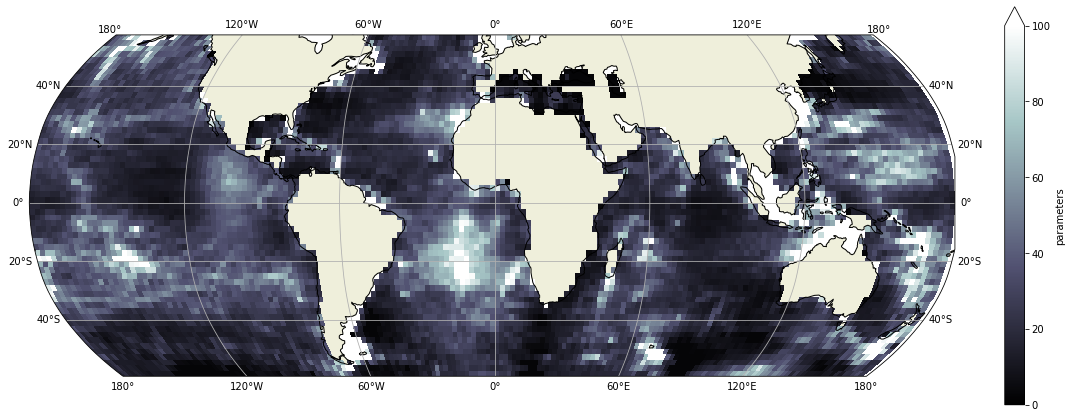

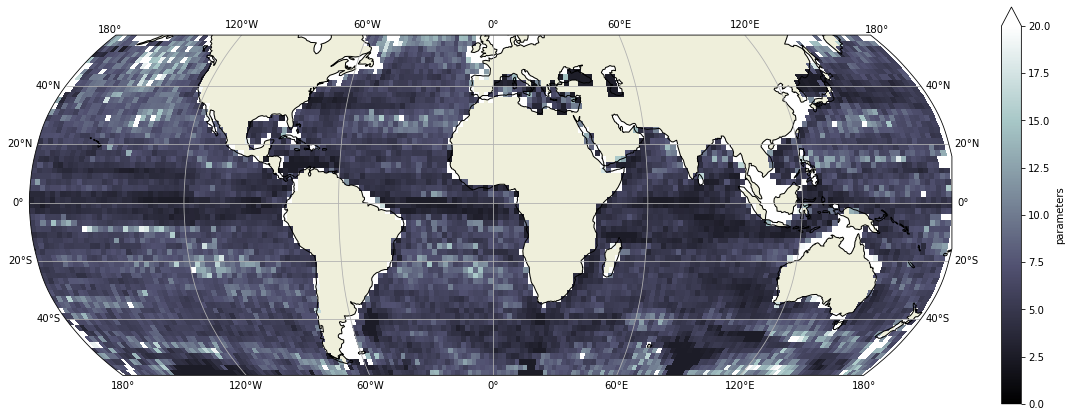

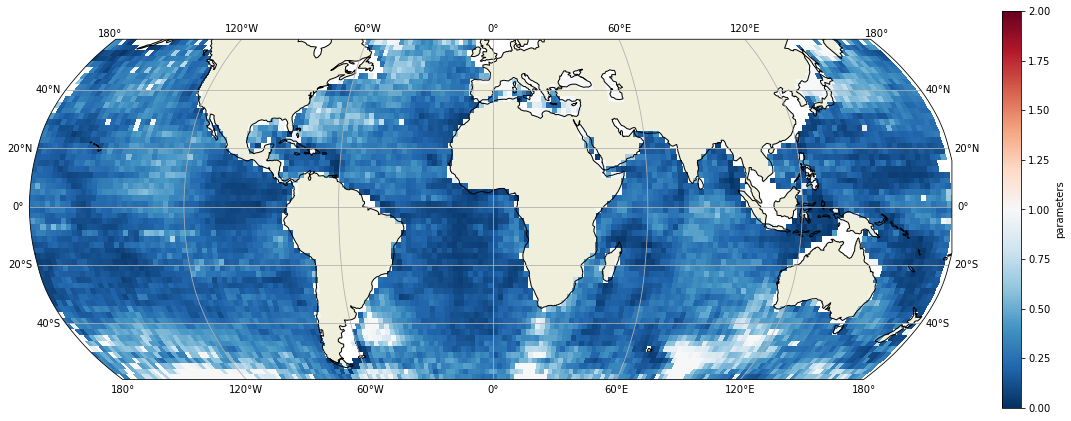

tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 5 memory: 20 MB fds: 200>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/croco/lib/python3.8/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/opt/anaconda3/envs/croco/lib/python3.8/site-packages/distributed/system_monitor.py", line 96, in update
    read_bytes = (ioc.bytes_recv - last.bytes_recv) / (duration or 0.5)
AttributeError: 'NoneType' object has no attribute 'bytes_recv'


In [44]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_out.sel(param='T').parameters,colmap='bone',vlim=(0,100))
ax.set_title('')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/Teestimate_SSU.png',bbox_inches='tight')
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(dsL_out.sel(param='T').parameters,colmap='bone',vlim=(0,20))
ax.set_title('')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/Tlestimate_SSU.png',bbox_inches='tight')

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps((dsL_out/ds_out).sel(param='T').parameters,colmap='RdBu_r',vlim=(0,2))
ax.set_title('')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/TlTeestimate_SSU.png',bbox_inches='tight')

##### Zoom Gulf stream

In [138]:
lat0,lat1 = 34,44
lon0,lon1 = -78,-66

In [156]:
dsi_hf = hf_dl2.sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))
dsi_lf = low_dl2.sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))

dsi_hf_out = xr.merge([dsE_out.parameters,dsL_out.parameters.rename('L_parameters')]
                     ).sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))
dsi_lf_out = xr.merge([dsE_low_out.parameters,dsL_low_out.parameters.rename('L_parameters')]
                     ).sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))

In [157]:
dsi_hf_out

<xarray.Dataset>
Dimensions:       (lon_bins: 6, lat_bins: 5, param: 2)
Coordinates:
  * lon_bins      (lon_bins) float64 -77.0 -75.0 -73.0 -71.0 -69.0 -67.0
  * lat_bins      (lat_bins) float64 35.0 37.0 39.0 41.0 43.0
  * param         (param) <U1 'T' 'V'
Data variables:
    parameters    (lon_bins, lat_bins, param) float64 nan nan nan ... nan nan
    L_parameters  (lat_bins, lon_bins, param) float64 nan nan 2.5 ... nan nan

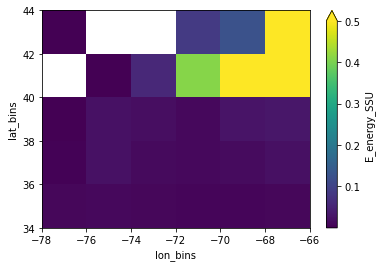

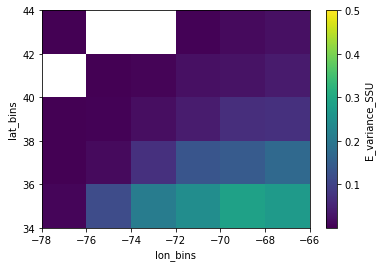

In [149]:
dsi_hf.E_energy_SSU.plot(y='lat_bins',vmax=0.5)
plt.figure()
dsi_lf.E_variance_SSU.plot(y='lat_bins',vmax=0.5)

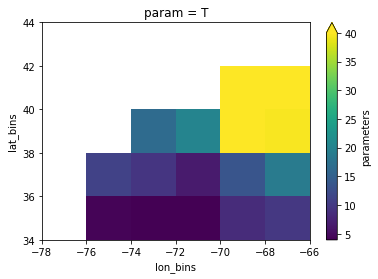

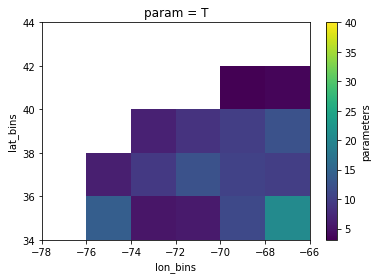

In [162]:
dsi_hf_out.sel(param='T').parameters.plot(y='lat_bins',vmax=40)
plt.figure()
dsi_lf_out.sel(param='T').parameters.plot(y='lat_bins',vmax=40)

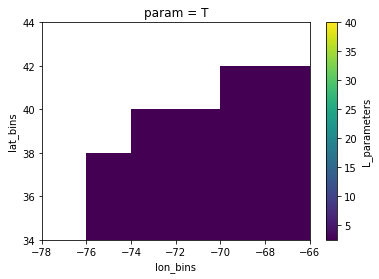

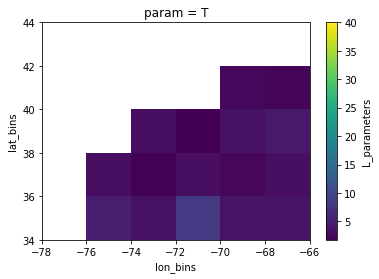

In [163]:
dsi_hf_out.sel(param='T').L_parameters.plot(y='lat_bins',vmax=40)
plt.figure()
dsi_lf_out.sel(param='T').L_parameters.plot(y='lat_bins',vmax=40)

In [31]:
cluster.close()